In [1]:
pip install pandas numpy scikit-learn nltk matplotlib seaborn tqdm jupyter

Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
import numpy as np
import re
import unicodedata
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import display, HTML
from tqdm import tqdm
import matplotlib.font_manager as fm
import requests
from io import BytesIO
import tempfile
import zipfile
#import matplotlib as mpl
import os
import shutil


In [5]:
try:
    # Try to find a font that supports Ethiopic characters
    ethiopic_font = None
    for font in fm.fontManager.ttflist:
        if 'Ethiopic' in font.name:
            ethiopic_font = font.name
            break
    
    if ethiopic_font:
        plt.rcParams['font.family'] = ethiopic_font
    else:
        # Fallback to DejaVu Sans which has partial support
        plt.rcParams['font.family'] = 'DejaVu Sans'
except:
    pass

tqdm.pandas()

In [7]:
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
print("✓ NLTK data downloaded\n")

✓ NLTK data downloaded



In [13]:
try:
    df = pd.read_csv(r'C:\Users\hp\Downloads\archive\Amharic News Dataset.csv', encoding='utf-8') 
    print("✓ Dataset loaded successfully")
    print(f"Shape: {df.shape}")
    print("\nFirst 3 rows:")
    display(df.head(3))
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

✓ Dataset loaded successfully
Shape: (51483, 6)

First 3 rows:


,headline,category,date,views,article,link
0,የኦሊምፒክ ማጣሪያ ተሳታፊዎች የሚለዩበት ቻምፒዮና እየተካሄደ ይገኛል,ስፖርት,"January 14, 2021",2,ብርሃን ፈይሳየኢትዮጵያ ቦክስ ፌዴሬሽን በየዓመቱ የሚያዘጋጀው የክለቦች ቻ...,https://www.press.et/Ama/?p=39481
1,አዲስ ዘመን ድሮ,መዝናኛ,"December 28, 2020",4,የአዲስ ዘመን ጋዜጣ ቀደምት ዘገባዎች በእጅጉ ተነባቢ ዛሬም ላገኛቸው በ...,https://www.press.et/Ama/?p=38334
2,የአረንጓዴ ጎርፍ በጎ አድራጎት አምባሳደሮች ተሰየሙ,ስፖርት,"January 6, 2021",6,ቦጋለ አበበየአዲስ አበባ ከተማ አስተዳደር ስፖርት ኮሚሽን ከኢትዮጵያ አረ...,https://www.press.et/Ama/?p=39010


In [17]:
print("\nBasic statistics before preprocessing:")
print("Category distribution:")
display(df['category'].value_counts())
    
# Article length analysis
df['article_length'] = df['article'].str.len()
print("\nArticle length statistics (characters):")
display(df['article_length'].describe())
    
    


Basic statistics before preprocessing:
Category distribution:


category
ሀገር አቀፍ ዜና    20674
ስፖርት          10411
ፖለቲካ           9325
ዓለም አቀፍ ዜና     6543
ቢዝነስ           3894
መዝናኛ            635
Name: count, dtype: int64


Article length statistics (characters):


count    51483.000000
mean      1343.940446
std       1288.947373
min          1.000000
25%        552.000000
50%        982.000000
75%       1706.000000
max      36219.000000
Name: article_length, dtype: float64

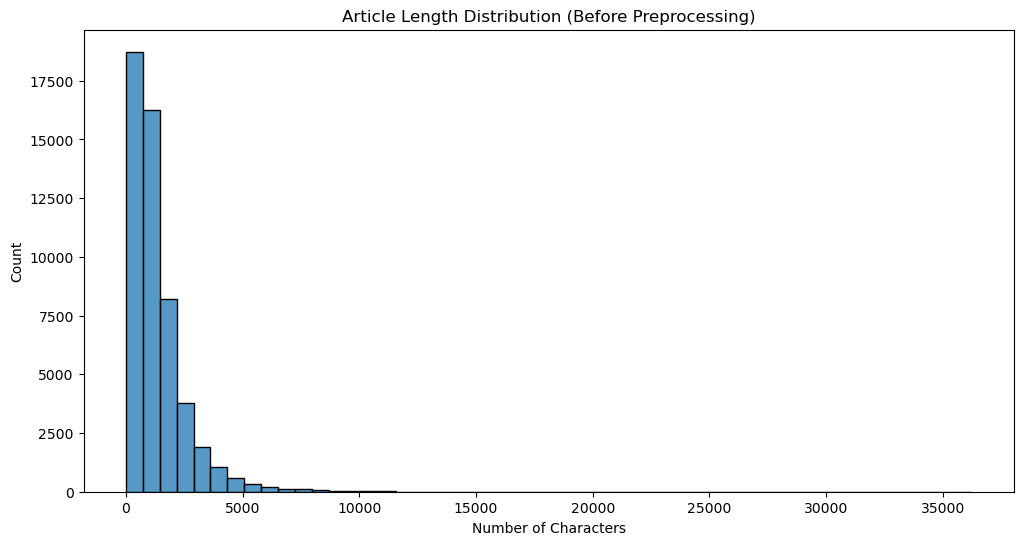

In [21]:
# Plot article length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['article_length'], bins=50)
plt.title('Article Length Distribution (Before Preprocessing)')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.show()

In [33]:
display(df.isna().sum())

# Check for any duplicated rows
total_duplicates = df.duplicated().sum()
print("dublicated rows: ",total_duplicates)
# Count duplicated values in each column
for col in df.columns:
    dup_count = df[col].duplicated().sum()
    print(f"Column '{col}' has {dup_count} duplicated values")


headline          13
category           1
date               0
views              0
article            0
link               0
article_length     0
dtype: int64

dublicated rows:  588
Column 'headline' has 1387 duplicated values
Column 'category' has 51476 duplicated values
Column 'date' has 45294 duplicated values
Column 'views' has 47075 duplicated values
Column 'article' has 1198 duplicated values
Column 'link' has 705 duplicated values
Column 'article_length' has 46115 duplicated values


In [93]:
df = df.dropna(subset=['article', 'category'])
df['headline'] = df['headline'].fillna('')
df['views'] = df['views'].fillna(0)


In [45]:
if np.issubdtype(df['category'].dtype, np.number):
    # Create mapping from numeric codes to meaningful names
    category_mapping = {
        0: 'Politics',
        1: 'Sports',
        2: 'Technology',
        3: 'Health',
        4: 'Entertainment'
        # Add more mappings as needed
    }
    df['category'] = df['category'].map(category_mapping).fillna('Other')

print("\n✓ Data cleaned")
print("Missing values after cleaning:")
display(df.isna().sum())


df = df.drop_duplicates()
total_duplicates = df.duplicated().sum()
print("dublicated rows: ",total_duplicates)



✓ Data cleaned
Missing values after cleaning:


headline          0
category          0
date              0
views             0
article           0
link              0
article_length    0
dtype: int64

dublicated rows:  0


In [47]:
def preprocess_amharic(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Normalize Unicode
    text = unicodedata.normalize('NFC', text)
    
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#', '', text)
    
    # Keep only Amharic characters and basic punctuation
    text = re.sub(r'[^\u1200-\u137F\s.,!?።፣]', '', text)
    
    # Tokenize and clean
    try:
        tokens = word_tokenize(text)
        tokens = [token.strip() for token in tokens if token.strip()]
        return ' '.join(tokens)
    except:
        return text  # fallback to original text if tokenization fails

# Apply preprocessing with progress bar
df['processed_text'] = df['article'].progress_apply(preprocess_amharic)
df = df[df['processed_text'].str.len() > 0]

print("\n✓ Text preprocessing complete")
print("Sample processed text:")
display(df[['article', 'processed_text']].head(2))

# Display statistics after preprocessing
df['processed_length'] = df['processed_text'].str.len()
print("\nArticle length statistics after preprocessing (characters):")
display(df['processed_length'].describe())

100%|███████████████████████████████████████████████████████████████████████████| 50894/50894 [01:43<00:00, 491.13it/s]



✓ Text preprocessing complete
Sample processed text:


,article,processed_text
0,ብርሃን ፈይሳየኢትዮጵያ ቦክስ ፌዴሬሽን በየዓመቱ የሚያዘጋጀው የክለቦች ቻ...,ብርሃን ፈይሳየኢትዮጵያ ቦክስ ፌዴሬሽን በየዓመቱ የሚያዘጋጀው የክለቦች ቻ...
1,የአዲስ ዘመን ጋዜጣ ቀደምት ዘገባዎች በእጅጉ ተነባቢ ዛሬም ላገኛቸው በ...,የአዲስ ዘመን ጋዜጣ ቀደምት ዘገባዎች በእጅጉ ተነባቢ ዛሬም ላገኛቸው በ...



Article length statistics after preprocessing (characters):


count    50815.000000
mean      1311.770619
std       1269.068342
min          1.000000
25%        534.000000
50%        951.000000
75%       1664.500000
max      35703.000000
Name: processed_length, dtype: float64

In [51]:
font_url = "https://software.sil.org/downloads/r/abyssinica/AbyssinicaSIL-2.200.zip"
try:
    response = requests.get(font_url)
    with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as tmp_file:
        tmp_file.write(response.content)
        tmp_path = tmp_file.name
    
    with zipfile.ZipFile(tmp_path, 'r') as zip_ref:
        zip_ref.extractall(tempfile.gettempdir())
    
    # Install the font
    font_path = Path(tempfile.gettempdir()) / "AbyssinicaSIL-2.200" / "AbyssinicaSIL-R.ttf"
    fm.fontManager.addfont(str(font_path))
    print(f"Font temporarily installed at: {font_path}")
except Exception as e:
    print(f"Error installing font: {e}")


Error installing font: name 'Path' is not defined


In [68]:
import matplotlib as mpl
cache_dir = mpl.get_cachedir()
print(f"Matplotlib cache directory: {cache_dir}")

try:
    # Delete the entire cache directory
    #import shutil
    shutil.rmtree(cache_dir)
    print("Successfully cleared matplotlib cache")
except Exception as e:
    print(f"Error clearing cache: {e}")

Matplotlib cache directory: C:\Users\hp\.matplotlib
Successfully cleared matplotlib cache


In [70]:
mpl.rcParams.update(mpl.rcParamsDefault)
available_fonts = [f.name for f in fm.fontManager.ttflist]
amharic_fonts = [f for f in available_fonts if 'Abyssinica' in f or 'Ethiopic' in f]
print("Available Amharic fonts:", amharic_fonts)

if not amharic_fonts:
    print("\nNo Amharic fonts found! Trying fallback solutions...")
    # Try with Windows' built-in Ethiopic font
    plt.rcParams['font.family'] = 'Ebrima'
    print("Using fallback font: Ebrima")
else:
    plt.rcParams['font.family'] = amharic_fonts[0]

Available Amharic fonts: ['Abyssinica SIL']


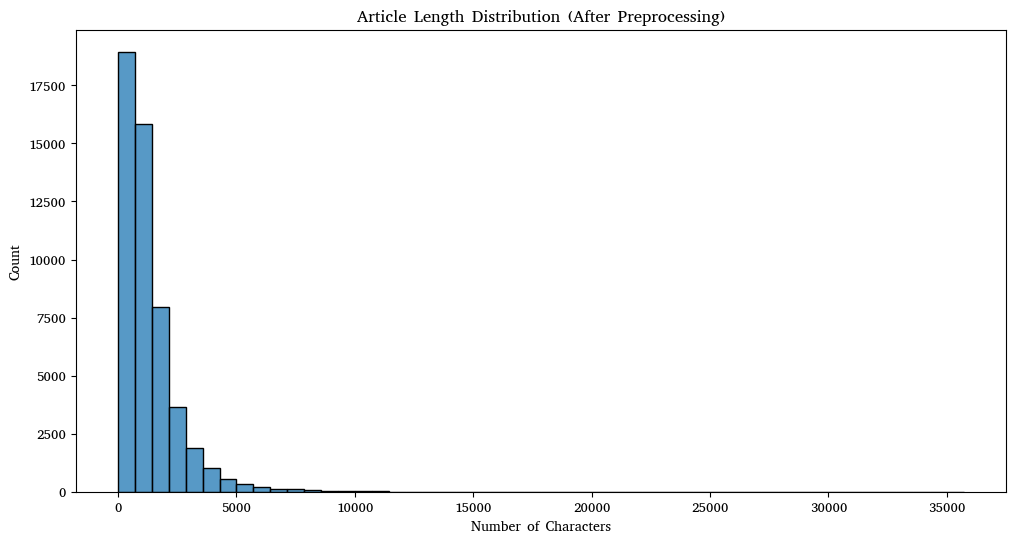

In [72]:
plt.figure(figsize=(12, 6))
sns.histplot(df['processed_length'], bins=50)
plt.title('Article Length Distribution (After Preprocessing)')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_9560\2057050825.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis")


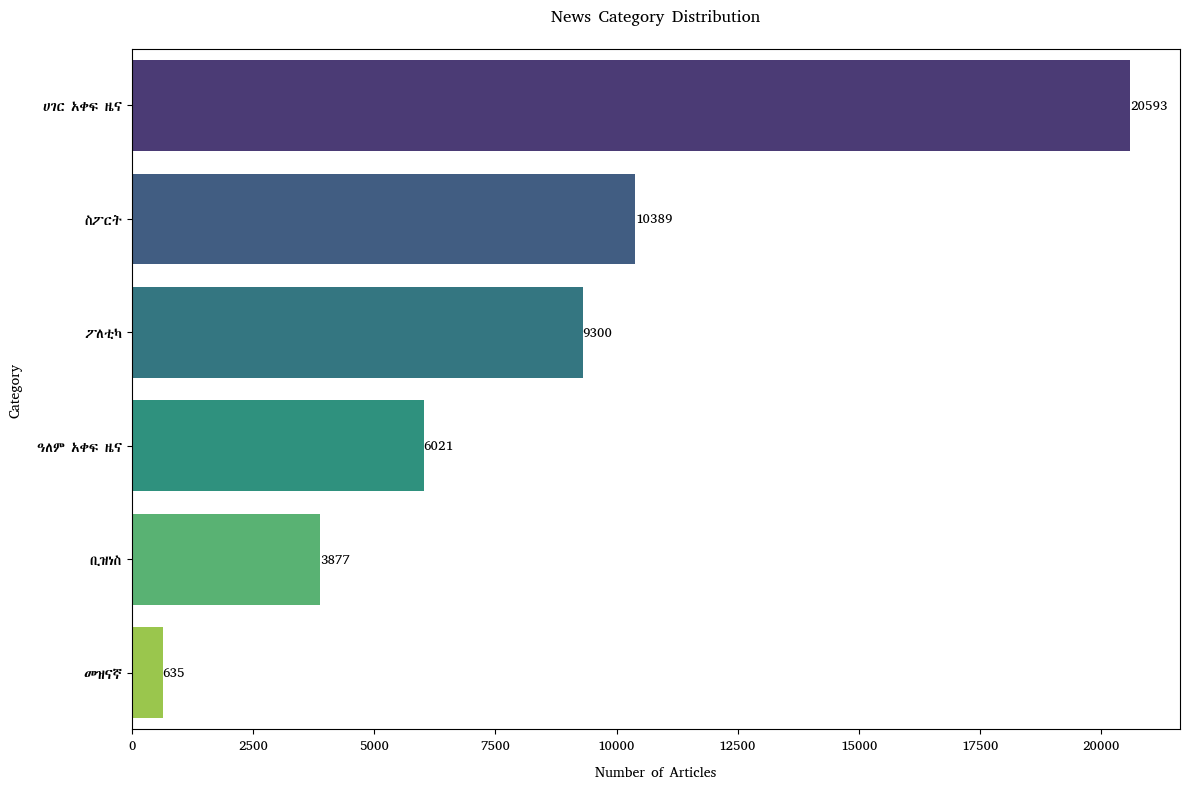


Category counts:


category
ሀገር አቀፍ ዜና    20593
ስፖርት          10389
ፖለቲካ           9300
ዓለም አቀፍ ዜና     6021
ቢዝነስ           3877
መዝናኛ            635
Name: count, dtype: int64

In [74]:
#exploratory data analysis
plt.figure(figsize=(12, 8))
category_counts = df['category'].value_counts()
ax = sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis")

# Add value labels
for i, v in enumerate(category_counts.values):
    ax.text(v + 0.2, i, str(v), color='black', va='center')

plt.title('News Category Distribution', pad=20)
plt.xlabel('Number of Articles', labelpad=10)
plt.ylabel('Category', labelpad=10)
plt.tight_layout()
plt.show()

print("\nCategory counts:")
display(category_counts)


In [80]:
#Feature Engineering
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)

X = tfidf.fit_transform(df['processed_text'])
y = df['category']

print("\n✓ Features created")
print(f"Feature matrix shape: {X.shape}")


✓ Features created
Feature matrix shape: (50815, 5000)


In [81]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("✓ Data split complete")
print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

✓ Data split complete
Train size: 40652
Test size: 10163



Training Logistic Regression...
Logistic Regression Accuracy: 0.83
Classification Report:


,precision,recall,f1-score,support
ሀገር አቀፍ ዜና,0.882050,0.789755,0.833355,4119.000000
መዝናኛ,0.606383,0.897638,0.723810,127.000000
ስፖርት,0.946008,0.986526,0.965842,2078.000000
ቢዝነስ,0.598309,0.730323,0.657757,775.000000
ዓለም አቀፍ ዜና,0.806870,0.877907,0.840891,1204.000000
ፖለቲካ,0.743562,0.745161,0.744361,1860.000000
accuracy,0.829086,0.829086,0.829086,0.829086
macro avg,0.763864,0.837885,0.794336,10163.000000
weighted avg,0.835793,0.829086,0.830290,10163.000000


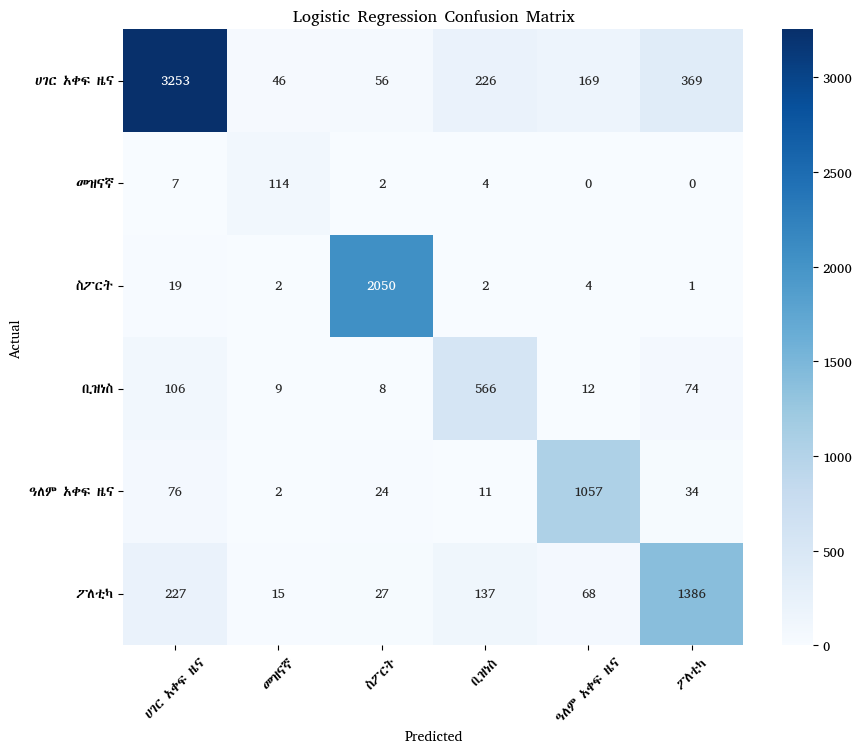


Training Naive Bayes...
Naive Bayes Accuracy: 0.77
Classification Report:


,precision,recall,f1-score,support
ሀገር አቀፍ ዜና,0.766778,0.782229,0.774426,4119.000000
መዝናኛ,0.522989,0.716535,0.604651,127.000000
ስፖርት,0.976328,0.893167,0.932898,2078.000000
ቢዝነስ,0.555046,0.624516,0.587735,775.000000
ዓለም አቀፍ ዜና,0.758002,0.806478,0.781489,1204.000000
ፖለቲካ,0.676284,0.630108,0.652380,1860.000000
accuracy,0.767096,0.767096,0.767096,0.767096
macro avg,0.709238,0.742172,0.722263,10163.000000
weighted avg,0.772830,0.767096,0.768970,10163.000000


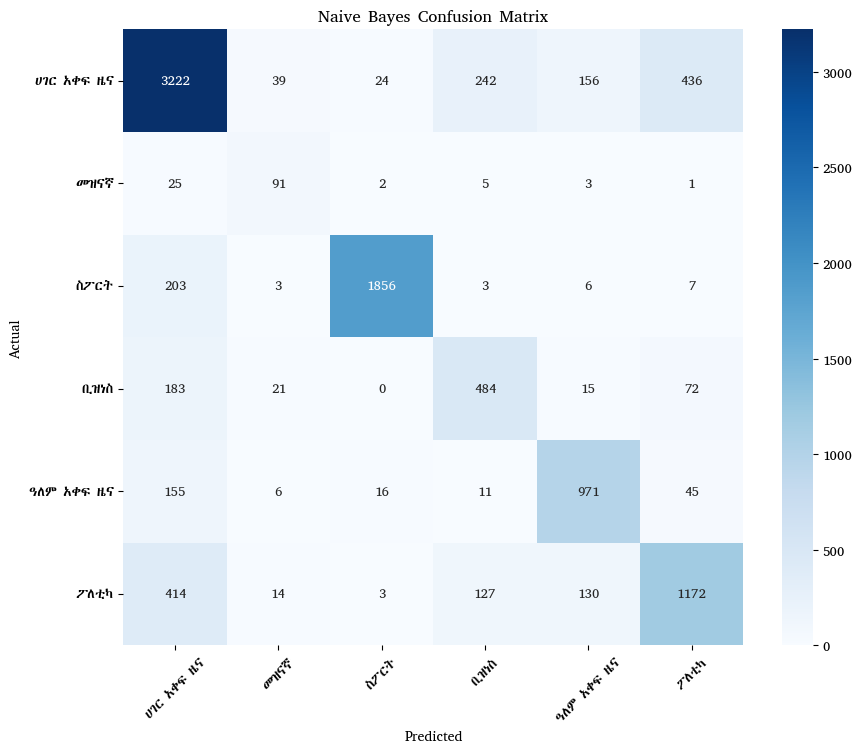

In [83]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'
    ),
    'Naive Bayes': MultinomialNB()
}
results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'model': name,
        'accuracy': accuracy,
        'report': report
    })
    
    print(f"{name} Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    display(pd.DataFrame(report).transpose())
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, 
                yticklabels=model.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [89]:
# best model comparision
best_model = max(results, key=lambda x: x['accuracy'])    
print("\nModel comparison:")
results_df = pd.DataFrame(results)[['model', 'accuracy']]
display(HTML(results_df.to_html(index=False)))
    
print(f"\nBest model: {best_model['model']} (Accuracy: {best_model['accuracy']:.4f})")
    
#except Exception as e:
   # print(f"⚠ Error during model training or evaluation: {str(e)}")
    #raise


Model comparison:


model,accuracy
Logistic Regression,0.829086
Naive Bayes,0.767096



Best model: Logistic Regression (Accuracy: 0.8291)


In [91]:
try:
    joblib.dump(best_model['model'], 'best_amharic_classifier.pkl')
    joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
    
    print("✓ Model and vectorizer saved successfully")
    print("Saved files:")
    print("- best_amharic_classifier.pkl")
    print("- tfidf_vectorizer.pkl")
    
except Exception as e:
    print(f"⚠ Error saving model: {str(e)}")
    raise

# 11. FINAL OUTPUT
print("\n" + "="*50)
print("AMHARIC NEWS CLASSIFICATION PIPELINE COMPLETED SUCCESSFULLY")
print("="*50)
print(f"\nBest model: {best_model['model']}")
print(f"Test accuracy: {best_model['accuracy']:.2%}")
print("\nVisualizations saved:")
print("- amharic_category_distribution.png")
print("- text_length_distributions.png")
print("- confusion_matrix_logistic_regression.png")
print("- confusion_matrix_naive_bayes.png")
print("\nModels saved:")
print("- best_amharic_classifier.pkl")
print("- tfidf_vectorizer.pkl")

✓ Model and vectorizer saved successfully
Saved files:
- best_amharic_classifier.pkl
- tfidf_vectorizer.pkl

AMHARIC NEWS CLASSIFICATION PIPELINE COMPLETED SUCCESSFULLY

Best model: Logistic Regression
Test accuracy: 82.91%

Visualizations saved:
- amharic_category_distribution.png
- text_length_distributions.png
- confusion_matrix_logistic_regression.png
- confusion_matrix_naive_bayes.png

Models saved:
- best_amharic_classifier.pkl
- tfidf_vectorizer.pkl
